In this example we will learn how to use a machine learning classifier to distinguish events with e+ mu+/K+ mu-/K- p and e+ pi+ pi- p . If you haven't already I recommend you read http://themlbook.com/wiki/doku.php.

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from joblib import dump
import numpy as np
import math
from matplotlib.colors import LogNorm
# when importing from keras we need to use the tensorflow backend ie like the following:
import tensorflow.keras

In this cell we're going to load in our data and do some general pre-processing. The data can be represented by a table where each row corresponds to an event that we want to classify and each column corresponds to a variable which we will use to classify the events.

First we're going to load the data into a pandas dataframe as it's a more convenient data format to handle. 

Next we're going to define some variables that we want to remove as we don't want to train our classifier on them. For example, the EBPid (Event Builder Particle Identification) variables already assigns a particle type to the different particles in your dataset. As we want to do our own particle identification, and ideally improve on the EBPid, we don't want to include this variable.

Another reason to remove variables is if they aren't useful to our classifier. This is called feature selection, you can read more at:
                https://machinelearningmastery.com/feature-selection-machine-learning-python/
                
One of the reasons we do this is because we have a large number of variables which makes our events harder to classify. To solve this issue we can do what is know as dimensionality reduction, you can read more at:
                https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/
                
Next, as we loop over the variables in our dataset we apply masks to these variables, so that our dataset only contains sensible values. You might want to add more conditions on the data that you will train on, for example by removing entries where the energy depositions are 0 in all three calorimeters. This is generally referred to as cleaning up your dataset.

We then convert our pandas dataframe to a numpy array, as this data format can be passed directly to our classifiers. We also make sure that we have as many kaon/muon (signal) and pion (background) events as classifiers tend to work less well on inbalanced datasets. If you want you can also throw away events, this will allow you to run through this file faster but it will probably also decrease the accuracy of your classifier.

We then separate out the ep2muLabel (or p2kLabel) variable into an array called y, whilst we have all the other variables in an array called X. The reason for this is that in X we have the discriminating variables from which the classifier learns what to predict, and y we have the "true" answer that the classifier will compare to its predictions, allowing it to know when the predictions were correct or not.

Finally we standardise our data as classifiers work better on data where all variables are on the same scale. You can read more about other data transformation techniques here:
                https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
                

In [2]:
#Load file, get tree and get branches in the tree
file = uproot.open('KaonID.root') #change for kaon dataset
tree = file['particle']
branches = tree.arrays()
branchNames=tree.keys()

#Convert the awkward arry to a pandas dataframe
X_pd=ak.to_pandas(branches)
#print(X_pd.shape)

#Choose the variables that we want to remove
#variable_mask =['ElectronEBPid',
#                'parpEBPid',
#                'parmEBPid',
#                'pEBPid',
#                'ep2muQ2',
#                'ep2muW',
#                'ep2muMissE',
#                'ep2muMissP',
#                'ep2muMissMass2',
#                'ep2muMissMass',
#                'ep2muInvariantMass']

variable_mask =['ElectronEBPid',
                'parpEBPid',
                'parmEBPid',
                'pEBPid',
                'p2kQ2',
                'p2kW',
                'p2kMissE',
                'p2kMissP',
                'p2kMissMass2',
                'p2kMissMass',
                'p2kInvariantMass']

#Loop over all variables in the file
count=0
for i in range(0,len(branchNames)):
    #Apply masks to make sure we only have sensible values for all variables
    sensH_mask = X_pd[branchNames[i]] <1e9
    sensL_mask = X_pd[branchNames[i]] >-1e9
    nan_mask = X_pd[branchNames[i]] !=float("nan")
    X_pd=X_pd[sensH_mask & sensL_mask & nan_mask]
    
    #Remove variables from the dataset
    if branchNames[i] in variable_mask:
        X_pd=X_pd.drop([branchNames[i]], axis=1)
    else:
        print('X: Column '+str(count)+' '+branchNames[i])
        count=count+1
        
    
#print(X_pd.shape)    

#Masks to select signal or background events
muon_mask = X_pd['p2kLabel'] == 1 #change for kaon dataset
pion_mask = X_pd['p2kLabel'] == 0 #change for kaon dataset

#Separate signal and background events
X_sig_pd = X_pd[muon_mask]
X_bg_pd = X_pd[pion_mask]

#Create target array from ep2muLabel, this is 1 for signal 0 for background
y_sig_pd=X_pd.iloc[:,-1:][muon_mask]
y_bg_pd=X_pd.iloc[:,-1:][pion_mask]

#Remove the label variable from the dataset
X_sig_pd=X_sig_pd.drop('p2kLabel', axis=1) #change for kaon dataset
X_bg_pd=X_bg_pd.drop('p2kLabel', axis=1) #change for kaon dataset

#Convert to numpy
X_sig=X_sig_pd.to_numpy()
X_bg=X_bg_pd.to_numpy()

y_sig=y_sig_pd.to_numpy()
y_bg=y_bg_pd.to_numpy()

#print(X_sig.shape)
#print(X_bg.shape)

#Make sure we have as many signal and background events
if(len(X_bg)>len(X_sig)):
    X_bg=X_bg[0:len(X_sig),:]
    y_bg=y_bg[0:len(X_sig),:]
else:
    X_sig=X_sig[0:len(X_bg),:]
    y_sig=y_sig[0:len(X_bg),:]
    
#Note: if you want to only keep the N first events you can do this with
#X_sig=X_sig[0:N,:]
#y_sig=y_sig[0:N,:]
#X_bg=X_bg[0:N,:]
#y_bg=y_bg[0:N,:]
    
#print(X_sig.shape)
#print(y_sig.shape)

#print(X_bg.shape)
#print(y_bg.shape)

#Create arrays from both signal and background
X= np.vstack((X_sig,X_bg))
y= np.vstack((y_sig,y_bg))

#print(X.shape)
#print(y.shape)

#Standardise our data
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

X: Column 0 ElectronP
X: Column 1 ElectronTheta
X: Column 2 ElectronPhi
X: Column 3 ElectronSF
X: Column 4 ElectronEPCal
X: Column 5 ElectronEECin
X: Column 6 ElectronEECout
X: Column 7 ElectronLU
X: Column 8 ElectronLV
X: Column 9 ElectronLW
X: Column 10 ElectronDU
X: Column 11 ElectronDV
X: Column 12 ElectronDW
X: Column 13 ElectronM2U
X: Column 14 ElectronM2V
X: Column 15 ElectronM2W
X: Column 16 ElectronVz
X: Column 17 ElectronVt
X: Column 18 ElectronToF
X: Column 19 ElectronPath
X: Column 20 ElectronHypTime
X: Column 21 ElectronDeltaTime
X: Column 22 ElectronDeltaTimeVer
X: Column 23 ElectronDeltaE
X: Column 24 ElectronHTCC
X: Column 25 ElectronTrChi2
X: Column 26 ElectronRegion
X: Column 27 ElectronSector
X: Column 28 Electronchi2pid
X: Column 29 parmP
X: Column 30 parmTheta
X: Column 31 parmPhi
X: Column 32 parmSF
X: Column 33 parmEPCal
X: Column 34 parmEECin
X: Column 35 parmEECout
X: Column 36 parmLU
X: Column 37 parmLV
X: Column 38 parmLW
X: Column 39 parmDU
X: Column 40 parm

Next we split our data into training and testing datasets. Once we've trained our classifier on the training data we want to validate it on a separate dataset to make sure that our classifier isn't learning by heart the training dataset. This is called overfitting which is an important issue in machine learning.

What is over/underfitting:
                            https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
          
How to avoid it:
                            https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
                            
How to identify it:
                            https://machinelearningmastery.com/overfitting-machine-learning-models/

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

Next we train our classifier. Here we're using a MLP classifier which is a type of neural network. This was imported from the sklearn library. You should look up which other classifiers you can import from the sklearn library and try them out to see if they perform better than the MLP. You should also use the tensorflow.keras library to try out deep neural networks or convolutional neural networks (or anything else you think might be useful).

Another thing to note is that we pass some parameters to our classifier (activation, solver, max_iter... there's more if you look at https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). These are known as hyperparameters, and you should look up what these are when you try out a new type of classifier. By changing the hyperparameters we can tune our classifier to perform (ideally) better. Hyperparameter optimisation is an important part of using machine learning techniques, this is usually done either by hand (which can be slow and ineffective) or using more complicated methods which you can read up on.

Tour of machine learning algorithms:
                    https://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/
                    
sklearn classifiers:
                    https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
                    
Using keras for deep neural networks:
                    https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
                    
How to build a convolutional neural network:
                    https://towardsdatascience.com/classify-butterfly-images-with-deep-learning-in-keras-b3101fe0f98
                    
Hyperparameter optimisation:
                    https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568
                    

In [4]:
#The hyperparameters here are bad, you should try playing around with these and record what effect your changes had
mlp = MLPClassifier(max_iter=3)

#tree = DecisionTreeClassifier()

#knn=KNeighborsClassifier(n_neighbors=3)

#Note: I had to reshape y_train from (NEvents,1) to (NEvents,). This might change for different classifiers
model = mlp.fit(X_train, y_train.reshape(len(y_train),))

dump(model, 'mlp_kaon.joblib') 

C:\Users\reubz\.conda\envs\tfEnv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['mlp_kaon.joblib']

Next we want to evaluate our classifier ie we want to know how good it is. predict returns a 0 or 1 value for each event in the test array. This is the classifier's prediction if an event has kaons or pions (signal or background). predict_proba returns a probability that an event is of class 0 in column 0 and the probability that it is of class 1 in column 1. We call this the response. This is a more complete value than simply the prediction returned by predict. Note: these two functions might not work with keras classifiers.

The accuracy is the ratio of how many events were correctly identified over all the events in our dataset. It's the most basic metric by which we can judge our classifier but it's not the most informative. You should read up on different metrics and think about which metrics are better suited here. One thing that comes up often in the discussion of metrics are the elements of the confusion matrix:

True Positive (TP): in our case these are muon/kaon events (with ep2muLabel==1) for which our classifier predicts a label 1.

True Negative (TN): in our case these are pion events (with ep2muLabel==0) for which our classifier predicts a label 0.

False Positive (FP): in our case these are pion events (with ep2muLabel==0) for which our classifier predicts a label 1.

False Negative (FN): in our case these are muon/kaon events (with ep2muLabel==1) for which our classifier predicts a label 0.

Check out:
                                https://en.wikipedia.org/wiki/Confusion_matrix
and:   
        https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

In [5]:
y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy =","{:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy = 0.9275


Next we plot the response to make sure that the predictions for pions and muons/kaons are well separated. You should try to think about what other plots would help us understand how to improve our classification.

One final thing to note is that the accuracy value returned by y_pred is the accuracy we could calculate if we decided that any event with a response>=0.5 is classified as a signal event and any event with a response<0.5 is classified as a background event. Instead of using 0.5 you can set a threshold at any value between 0 and 1. You should plot how your metrics vary as you change this threshold value.

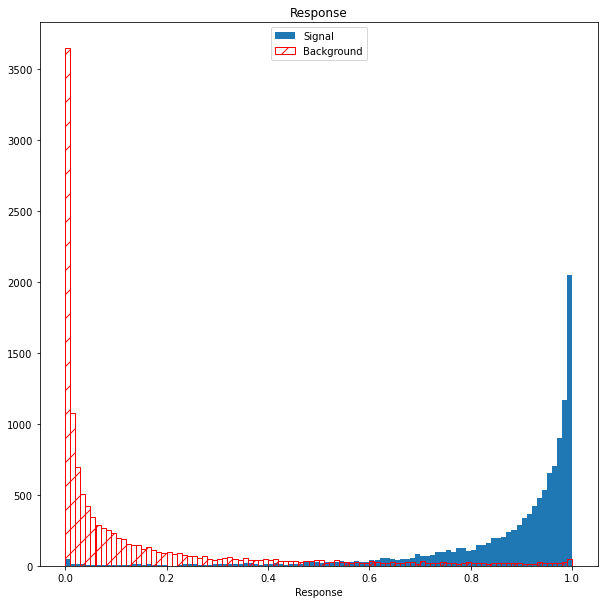

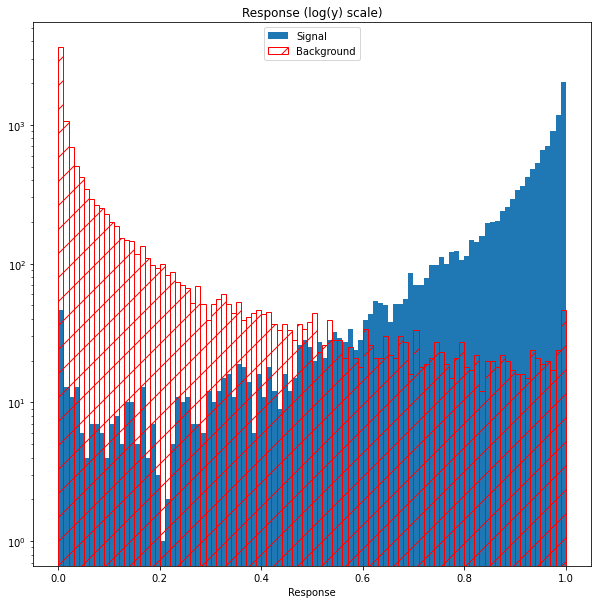

In [6]:
y_test=y_test.reshape(len(y_test),)

fig = plt.figure(figsize=(10,10))
plt.hist(y_proba[y_test==1], range=[0,1],bins=100, label='Signal')
plt.hist(y_proba[y_test==0], range=[0,1],bins=100, edgecolor='red',label='Background',hatch='/',fill=False)
plt.legend(loc='upper center')#can change upper to lower and center to left or right
plt.xlabel('Response')
plt.title('Response')
plt.show()

fig = plt.figure(figsize=(10,10))
plt.hist(y_proba[y_test==1], range=[0,1],bins=100, label='Signal')
plt.hist(y_proba[y_test==0], range=[0,1],bins=100, edgecolor='red',label='Background',hatch='/',fill=False)
plt.legend(loc='upper center')#can change upper to lower and center to left or right
plt.xlabel('Response')
plt.title('Response (log(y) scale)')
plt.yscale('log', nonpositive='clip')
plt.show()

[0.10896519 0.99412885 0.99429222 ... 0.94924534 0.96443303 0.85700443]
(23687,)
0.10896518879287609


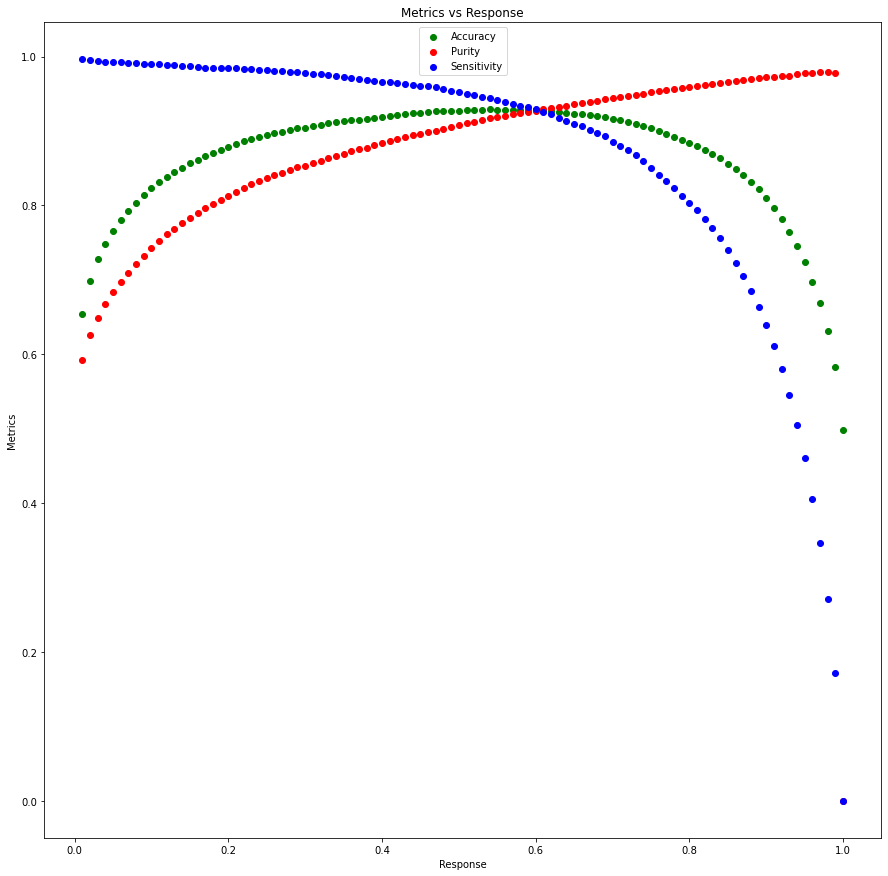

In [7]:
print(y_proba)
print(y_proba.shape)
print(y_proba[0])

thresh=[]
acc=[]
pur=[]
sen=[]
threshold=np.linspace(0.01,1,100)

for i in threshold:
    #print(i)
    FP=0                                                 #Reset confusion matrix elements everytime I change the threshold
    TP=0
    TN=0
    FN=0
    for event in range (0,len(y_proba),1):
        prob=y_proba[event]
        #print(prob.shape)
        if prob>i:               #If y_proba is above the threshold we classify that event as signal
            if y_test[event]==1:    
                 TP=TP+1                                    # Kaon event classified as signal
            else:
                  FP=FP+1                                   # Pion event classified as signal
        else:
            if y_test[event]==1:
                 FN=FN+1                                    # Kaon event classified as background
            else:
                  TN=TN+1                                   # Pion event classified as background
    if (TP+TN+FP+FN)!=0:
        Accuracy=(TP+TN)/(TP+TN+FP+FN)               #Accuracy at threshold
    else:
        Acc=0.5
    if (TP+FP)!=0:
        Pur=(TP)/(TP+FP)
    else:
        Pur=0
    if(TP+FN)!=0:
        Sen=(TP)/(TP+FN)
    else:
        Sen=0
    acc.append(Accuracy)
    pur.append(Pur)
    sen.append(Sen)
    thresh.append(i)
    
fig = plt.figure(figsize=(15,15))
plt.scatter(thresh,acc,marker='o',color='green', label='Accuracy')
plt.scatter(thresh,pur,marker='o',color='red', label='Purity')
plt.scatter(thresh,sen,marker='o',color='blue', label='Sensitivity')
plt.legend(loc='upper center')#can change upper to lower and center to left or right
plt.xlabel('Response')
plt.ylabel('Metrics')
plt.title('Metrics vs Response')
plt.show()


(23687, 118)
(23687, 1)
(23687,)


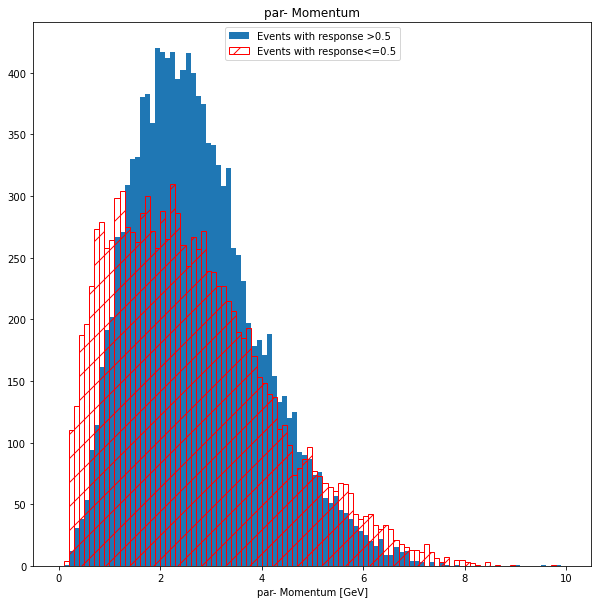

In [10]:
X_test_unsc=scaler.inverse_transform(X_test)

X_mom = X_test_unsc[:,29:30]

print(X_test.shape)
print(X_mom.shape)

print(y_proba.shape)

fig = plt.figure(figsize=(10,10))
plt.hist(X_mom[y_proba>0.5], range=[0,10],bins=100, label='Events with response >0.5')
plt.hist(X_mom[y_proba<=0.5], range=[0,10],bins=100, edgecolor='red',label='Events with response<=0.5',hatch='/',fill=False)
plt.legend(loc='upper center')#can change upper to lower and center to left or right
plt.xlabel('par- Momentum [GeV]')
plt.title('par- Momentum')
plt.show()

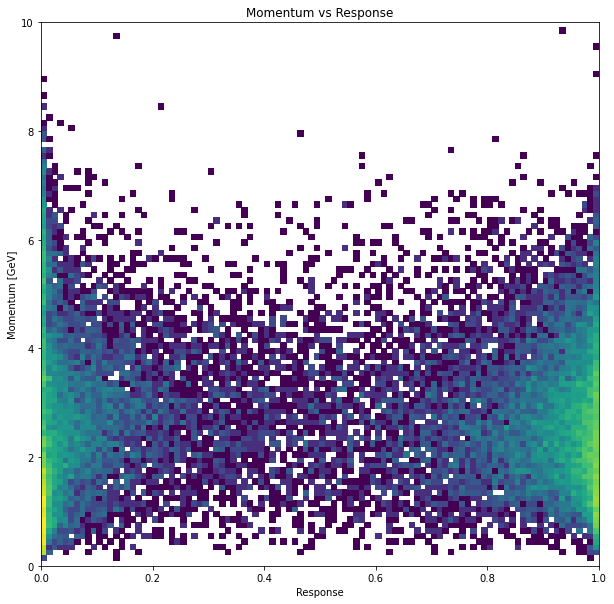

In [9]:
fig=plt.figure(figsize = (10,10))
plt.hist2d(x=y_proba,y=np.reshape(X_mom,len(X_mom)), bins=(100, 100), range=((0, 1),(0,10)),norm=LogNorm())
plt.xlabel('Response')
plt.ylabel('Momentum [GeV]')
#plt.xscale('log', nonpositive='clip')
plt.title('Momentum vs Response')
plt.show()